In [6]:
import tensorflow as tf
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import MaxPool2D
from CNN_BatchNorm import CNNModel
# from VGG16 import VGG16

In [7]:
# model = VGG16()
model = CNNModel()

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 61, 61, 64)        6464      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 57, 57, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 57, 57, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 57, 57, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 53, 53, 256)      

In [5]:
FEATURES_DICT = {
    'R': tf.io.FixedLenFeature([61, 61], dtype=tf.float32),  
    'G': tf.io.FixedLenFeature([61, 61], dtype=tf.float32),  
    'B': tf.io.FixedLenFeature([61, 61], dtype=tf.float32),    
    'L': tf.io.FixedLenFeature([61, 61], dtype=tf.float32),
    'class': tf.io.FixedLenFeature([1, 1], dtype=tf.float32)
  }


In [6]:
def parse_tfrecord(example_proto):
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)

def to_tuple(inputs):
  inputsList = [inputs.get(key) for key in ['R','G','B','L']]
  labels = inputs.get('class')
  # labels = parsed_features.pop('class')
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(['R','G','B','L','class'])], labels


def get_dataset(files):
  # glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord)
  dataset = dataset.map(to_tuple)
  
  return dataset

In [9]:
# Auth with cloud storage
!gcloud auth activate-service-account --key-file Your_Service_Account.json
!gsutil cp gs://your_cloud_storage/cars_training2.tfrecord.gz .
!gsutil cp gs://your_cloud_storage/cars_eval2.tfrecord.gz .

In [8]:
car_dataset = get_dataset('cars_training2.tfrecord.gz')
car_val_dataset = get_dataset('cars_training2.tfrecord.gz').batch(100)
car_dataset_batched = car_dataset.batch(100)

In [9]:
model.compile(optimizer='SGD', loss='BinaryCrossentropy', metrics=['accuracy'])

In [10]:
model.fit_generator(car_dataset_batched, validation_data=car_val_dataset,epochs=50, shuffle=True)

In [12]:
from matplotlib import pyplot as plt

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
(61, 61, 3)


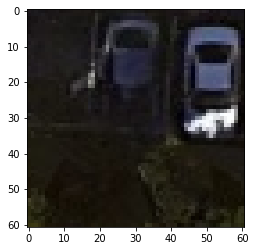

In [13]:
image_no=228
for idx,i in enumerate(car_dataset):
  if idx == image_no:
    image = tf.transpose(i[0],(2,0,1))
    print(i[1])
    print(i[0][:,:,:3].shape)
    plt.imshow(i[0][:,:,:3]/255)
    break

# Test

(61, 61, 4)
[[0.24182819]]
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


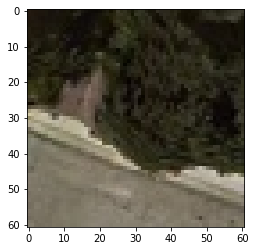

In [23]:
image_no=2000
for idx,i in enumerate(car_dataset):
  if idx == image_no:
    print(i[0].shape)
    print(model.predict(tf.expand_dims(i[0],axis=0)))
    print(i[1])
    plt.imshow(i[0][:,:,:3]/255)
    break